## Import Libraries

In [127]:
# read hdf5 file and plot the data
import h5py
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import plotly.express as px

## Load Data

In [128]:
# read the file
datafile_path = "../../data/"
# filename = datafile_path + "eye closed2023.11.29_11.05.35.hdf5"
filename = datafile_path + "eye open2023.11.29_10.56.28.hdf5"
# filename = datafile_path + "neck movement bottom left2024.03.01_10.53.24.hdf5"
# filename = datafile_path + "neck movement bottom right2024.03.01_10.43.37.hdf5"
# data = None
with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())

    # List all the groups in the file
    print("\nGroups in the HDF5 file:")
    print(list(f.keys()))

    # Print all the groups and datasets
    print("\nGroups and datasets in the HDF5 file:")
    for key in f.keys():
        print(key, f[key])
    # Print al the datasets in the RawData group
    print("\nDatasets in the RawData group:")
    print(list(f['RawData'].keys()))

    # Access a specific group
    data_samples = f['RawData']['Samples'][:]
    f.close()

Keys: <KeysViewHDF5 ['AsynchronData', 'RawData', 'SavedFeatues', 'Version']>

Groups in the HDF5 file:
['AsynchronData', 'RawData', 'SavedFeatues', 'Version']

Groups and datasets in the HDF5 file:
AsynchronData <HDF5 group "/AsynchronData" (1 members)>
RawData <HDF5 group "/RawData" (6 members)>
SavedFeatues <HDF5 group "/SavedFeatues" (1 members)>
Version <HDF5 group "/Version" (1 members)>

Datasets in the RawData group:
['AcquisitionTaskDescription', 'DAQDeviceCapabilities', 'DAQDeviceDescription', 'Samples', 'SessionDescription', 'SubjectDescription']


In [129]:
# Set the data and time array
data_samples = data_samples[5120:]  # Remove the first 5120 data points (10 sec)
data_shape = data_samples.shape # (179218, 15)
sampling_rate = 512             # Hz
duration = data_shape[0] / 512  # seconds
channels = data_shape[1]        # 15 channels
num_points = data_shape[0]      # 179218
print(f"Data shape: {data_shape}, Sampling rate: {sampling_rate} Hz, Duration: {duration} seconds, Channels: {channels}")

# Generate time array
time = np.arange(0, duration, 1 / sampling_rate)

# Create a pandas DataFrame from the data
raw_data_df = pd.DataFrame(data_samples, columns=[f"Channel_{i+1}" for i in range(data_shape[1])])
raw_data_df['Time'] = time
raw_data_df.head()

Data shape: (179218, 15), Sampling rate: 512 Hz, Duration: 350.03515625 seconds, Channels: 15


,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_9,Channel_10,Channel_11,Channel_12,Channel_13,Channel_14,Channel_15,Time
0,17664.382812,19512.478516,7186.674316,24946.027344,16872.628906,24073.351562,20894.835938,20476.388672,20572.218750,26150.902344,21962.773438,28179.748047,18629.376953,18385.812500,7922.527344,0.000000
1,17663.871094,19512.335938,7186.275391,24945.115234,16872.066406,24073.167969,20894.414062,20475.349609,20571.316406,26150.335938,21962.035156,28178.435547,18631.753906,18384.611328,7921.879395,0.001953
2,17663.451172,19512.292969,7186.045898,24944.222656,16871.507812,24073.085938,20894.230469,20474.359375,20570.443359,26149.974609,21961.542969,28177.292969,18634.189453,18383.691406,7921.477051,0.003906
3,17663.125000,19512.335938,7185.975098,24943.378906,16870.957031,24073.089844,20894.273438,20473.445312,20569.617188,26149.808594,21961.300781,28176.357422,18636.574219,18383.062500,7921.261719,0.005859
4,17662.886719,19512.447266,7186.040527,24942.619141,16870.414062,24073.148438,20894.505859,20472.626953,20568.855469,26149.804688,21961.291016,28175.662109,18638.802734,18382.730469,7921.168945,0.007812


In [130]:
# Change the data units from microvolts to volts
# data_array = np.divide(data_samples.T,1e6)

# Pass the dataframes to MNE
info = mne.create_info(ch_names=[f"Channel_{i+1}" for i in range(data_shape[1])], sfreq=sampling_rate, ch_types='eeg')
raw_data = mne.io.RawArray(data_samples.T, info)


Creating RawArray with float64 data, n_channels=15, n_times=179218
    Range : 0 ... 179217 =      0.000 ...   350.033 secs
Ready.


## Plot Raw EEG Data

In [131]:
# Plot using plotly express
raw_data_df = raw_data_df[(raw_data_df['Time']>0) & (raw_data_df['Time']<120)]
fig = px.line(
    raw_data_df, 
    x='Time', 
    y=raw_data_df.columns, 
    title='Raw EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

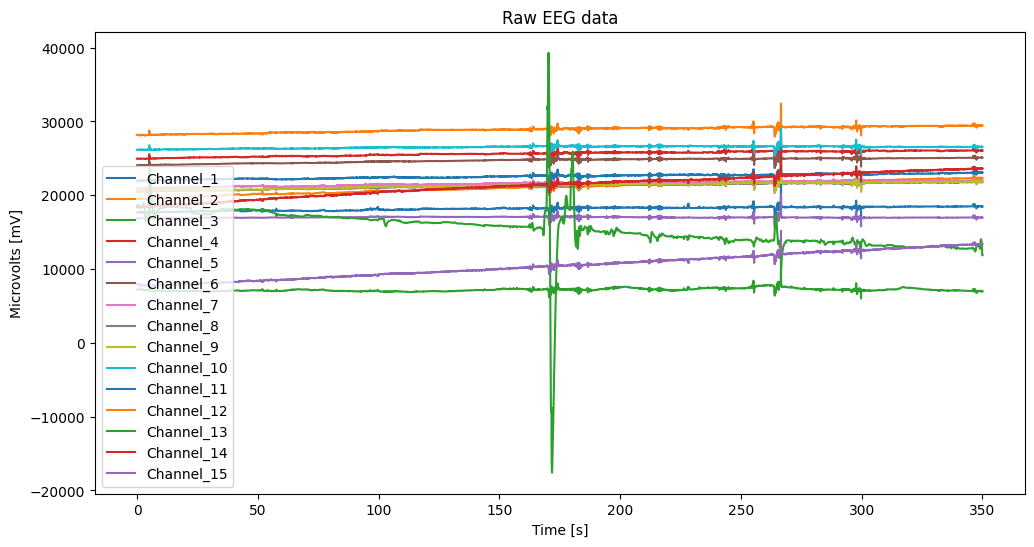

In [132]:
# Plot the raw EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, data_samples)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Raw EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

## Apply Band-pass Filter

In [133]:
# Apply a bandpass filter to the data using MNE
band_filtered_eeg = raw_data.filter(l_freq=0.1, h_freq=30, fir_design="firwin2")
band_data = band_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (66.002 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


### Plot by Plotly Express

In [134]:
# Plot the filtered data using plotly express
band_data_df = pd.DataFrame(band_data.T, columns=[f"Channel_{i+1}" for i in range(band_data.shape[0])])
band_data_df['Time'] = band_filtered_eeg.times
band_data_df = band_data_df[(band_data_df['Time']>0) & (band_data_df['Time']<120)]
fig = px.line(
    band_data_df, 
    x='Time', 
    y=band_data_df.columns, 
    title='Filtered EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

### Plot by Pyplot

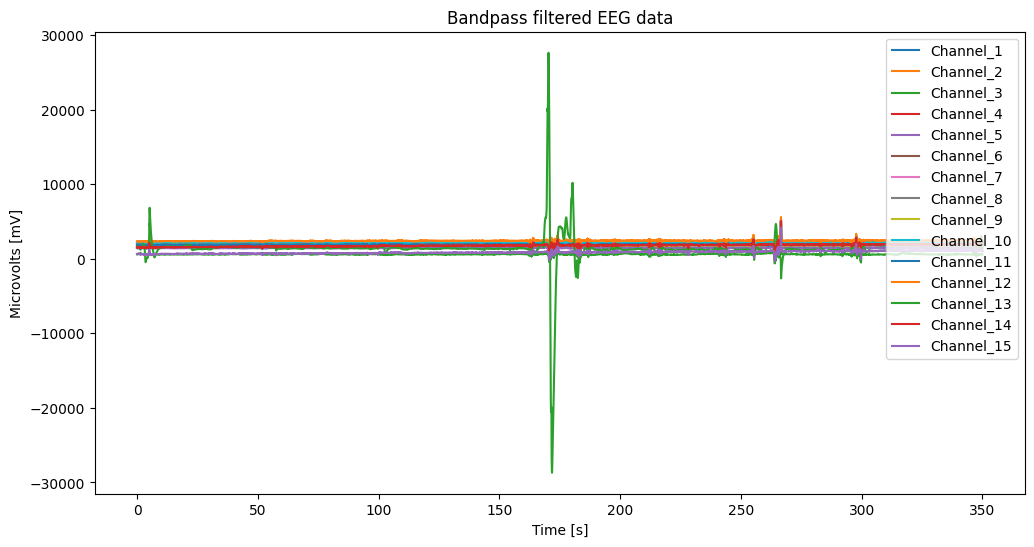

In [135]:
# Plot the bandpass filtered EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, band_data.T)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Bandpass filtered EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

## Apply Notch Filter

In [136]:
# Apply notch filter to the data using MNE
notch_filtered_eeg = band_filtered_eeg.notch_filter(freqs=60)
notch_data = notch_filtered_eeg.get_data()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


### Plot by Plotly Express

In [137]:
# Plot the notch filtered data using plotly express
notch_data_df = pd.DataFrame(notch_data.T, columns=[f"Channel_{i+1}" for i in range(notch_data.shape[0])])
notch_data_df['Time'] = notch_filtered_eeg.times
notch_data_df = notch_data_df[(notch_data_df['Time']>0) & (notch_data_df['Time']<120)]
fig = px.line(
    notch_data_df, 
    x='Time', 
    y=notch_data_df.columns, 
    title='Notch Filtered EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

### Plot by Pyplot

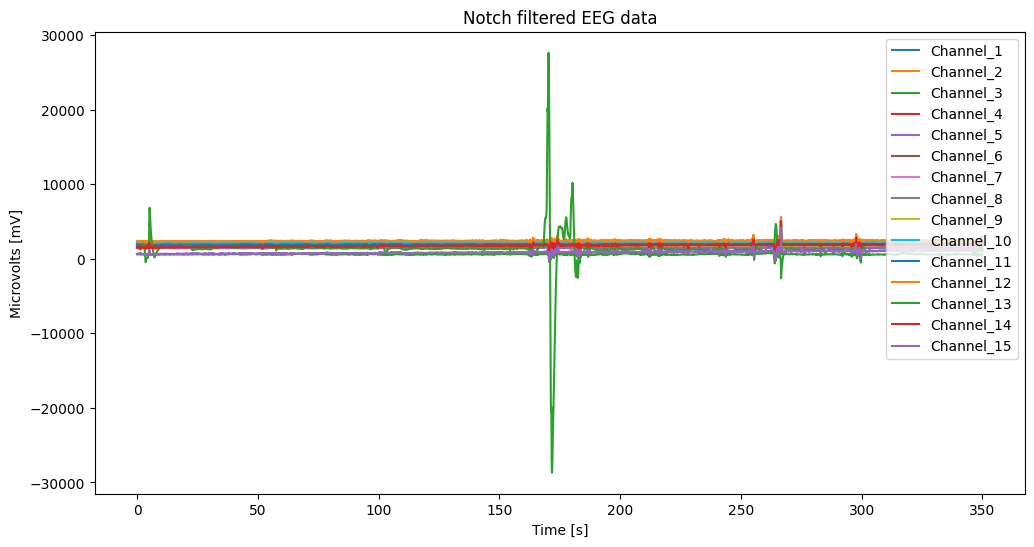

In [138]:
# Plot the notch filtered EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, notch_data.T)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Notch filtered EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

## Independent Component Analysis (ICA)

Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.9s.
Creating RawArray with float64 data, n_channels=15, n_times=179218
    Range : 0 ... 179217 =      0.000 ...   350.033 secs
Ready.


C:\Users\aiden\AppData\Local\Temp\ipykernel_7412\209824828.py:3: RuntimeWarning:

Using n_components=15 (resulting in n_components_=15) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.5) and smallest (6.1e-06) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 14



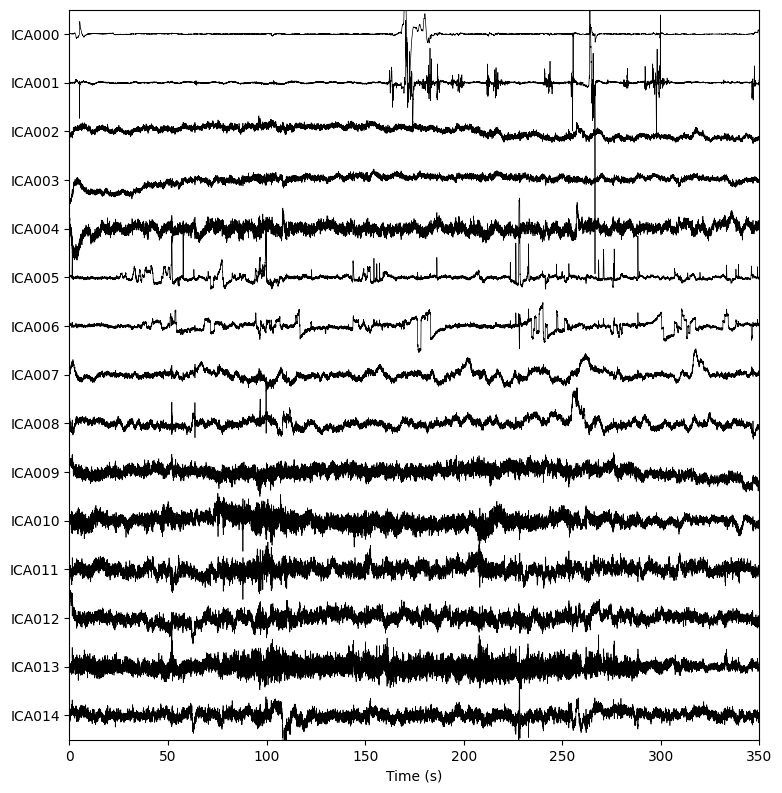

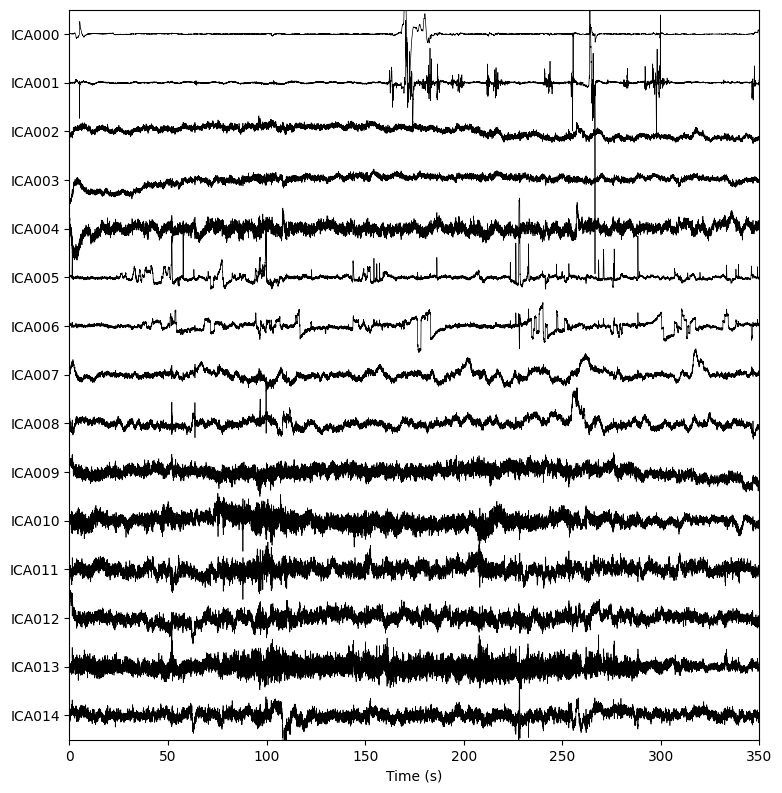

In [139]:
# Apply ICA to the data using MNE
ica = mne.preprocessing.ICA(n_components=channels, random_state=97, max_iter="auto")
ica.fit(notch_filtered_eeg)
ica.plot_sources(notch_filtered_eeg, show_scrollbars=False, start=0, stop=num_points)

In [140]:
ica

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,199 iterations on raw data (179218 samples)
ICA components,15
Available PCA components,15
Channel types,eeg
ICA components marked for exclusion,—


## Remove the EOG artifacts

In [141]:
# # Remove the EOG artifacts from the data using MNE
# eog_indices, eog_scores = ica.find_bads_eog(notch_filtered_eeg)
# ica.plot_scores(eog_scores)
# # No EOG channel(s) found

## Remove Artifact

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 15 PCA components


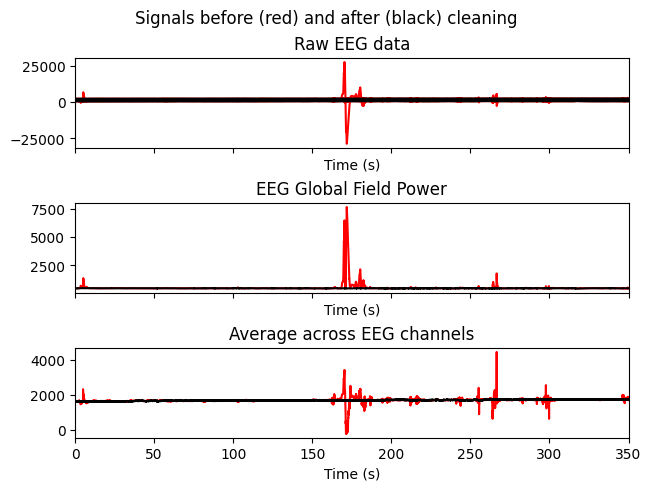

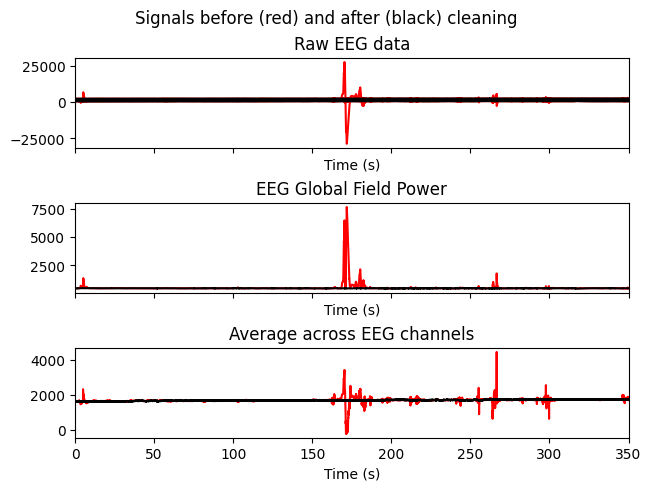

In [142]:
# blinks
exclude = [0, 1, 5, 6]
ica.plot_overlay(notch_filtered_eeg, exclude=exclude, picks="eeg", start=0, stop=num_points)

In [143]:
# Get Data that removed 0 component from the data using MNE
ica.exclude = exclude
cleaned_eeg = ica.apply(notch_filtered_eeg)
cleaned_eeg

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 15 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,15 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [144]:
# Plot the cleaned EEG data using plotly express
cleaned_data = cleaned_eeg.get_data()
cleaned_data_df = pd.DataFrame(cleaned_data.T, columns=[f"Channel_{i+1}" for i in range(cleaned_data.shape[0])])
cleaned_data_df['Time'] = cleaned_eeg.times 
cleaned_data_df = cleaned_data_df[(cleaned_data_df['Time']>0) & (cleaned_data_df['Time']<120)]
fig = px.line(
    cleaned_data_df, 
    x='Time', 
    y=cleaned_data_df.columns, 
    title='Cleaned EEG Data from 15 Channels',
    labels={'Time': 'Time (seconds)', 'value': 'Microvolts [mV]'})
# fig.show()

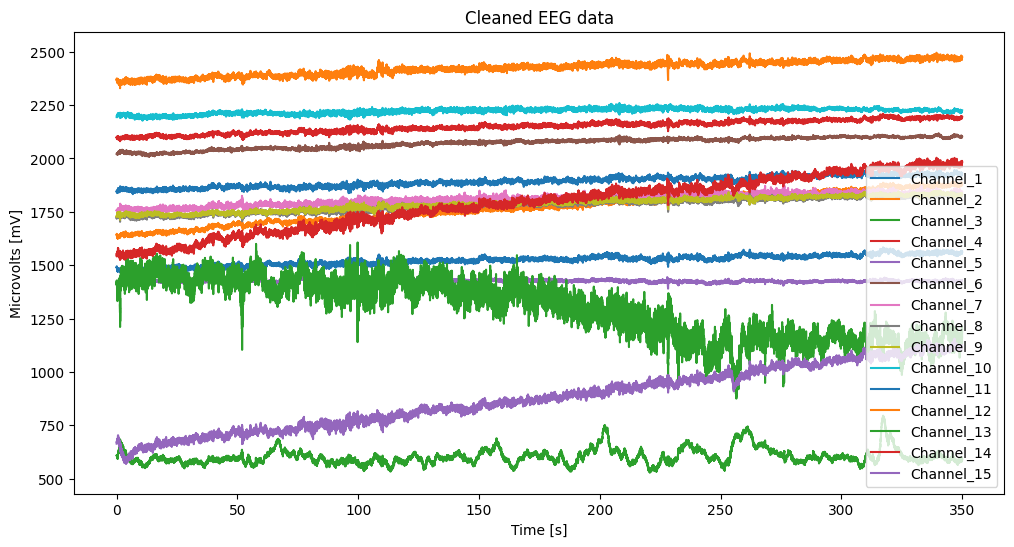

In [145]:
# Plot the cleaned EEG data using pyplot
# The data value on x-axis is recorded in 512 Hz, reformat the x-axis to seconds
x = np.arange(0, data_samples.shape[0], 1)
x = x / 512
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x, cleaned_data.T)
plt.xlabel('Time [s]')
plt.ylabel('Microvolts [mV]')
plt.title('Cleaned EEG data')
# Add the channel names to the plot
plt.legend([f"Channel_{i+1}" for i in range(data_shape[1])])
plt.show()

In [146]:
cleaned_data.shape

(15, 179218)

## Power Spectual Density

In [147]:
# Calculate the Power Spectral Density (PSD) of the cleaned EEG data 
# using MNE's mne.io.RawArray.compute_psd() method
# Two methods are used: Welch and Multitaper
welch_psd = cleaned_eeg.compute_psd(method='welch', fmin=0, fmax=30, n_fft=int(20*sampling_rate))
multitaper_psd = cleaned_eeg.compute_psd(method='multitaper', fmin=0, fmax=30)
welch_psd

Effective window size : 20.000 (s)


    Using multitaper spectrum estimation with 1 DPSS windows


C:\Users\aiden\AppData\Local\Temp\ipykernel_7412\1951302116.py:5: RuntimeWarning:

Could not properly use low_bias, keeping lowest-bias taper



Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Raw
Dims,"channel, freq"
Estimation method,welch
Number of channels,15
Number of frequency bins,601
Frequency range,0.00 – 30.00 Hz


### Delta Band

In [148]:
# Plot the delta band data (frequency between 0 to 4) from welch PSD using plotly express
welch_psd_df = welch_psd.to_data_frame(copy=True)
welch_psd_df_delta = welch_psd_df[(welch_psd_df['freq']>=0) & (welch_psd_df['freq']<=4)]
fig = px.line(
    welch_psd_df_delta, 
    x='freq', 
    y=welch_psd_df_delta.columns[1:], 
    title='Delta Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

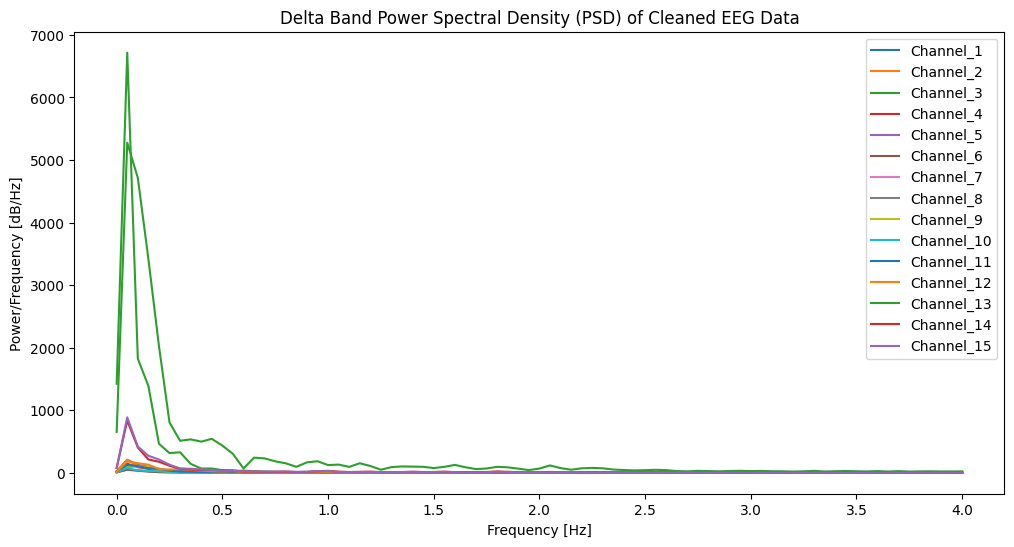

In [149]:
# Plot the delta band data (frequency between 0 to 4) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_delta['freq'], welch_psd_df_delta.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Delta Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_delta.columns[1:])
plt.show()

### Theta Band

In [150]:
# Plot the theta band data (frequency between 4 to 8) from welch PSD using plotly express
welch_psd_df_theta = welch_psd_df[(welch_psd_df['freq']>=4) & (welch_psd_df['freq']<=8)]
fig = px.line(
    welch_psd_df_theta, 
    x='freq', 
    y=welch_psd_df_theta.columns[1:], 
    title='Theta Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

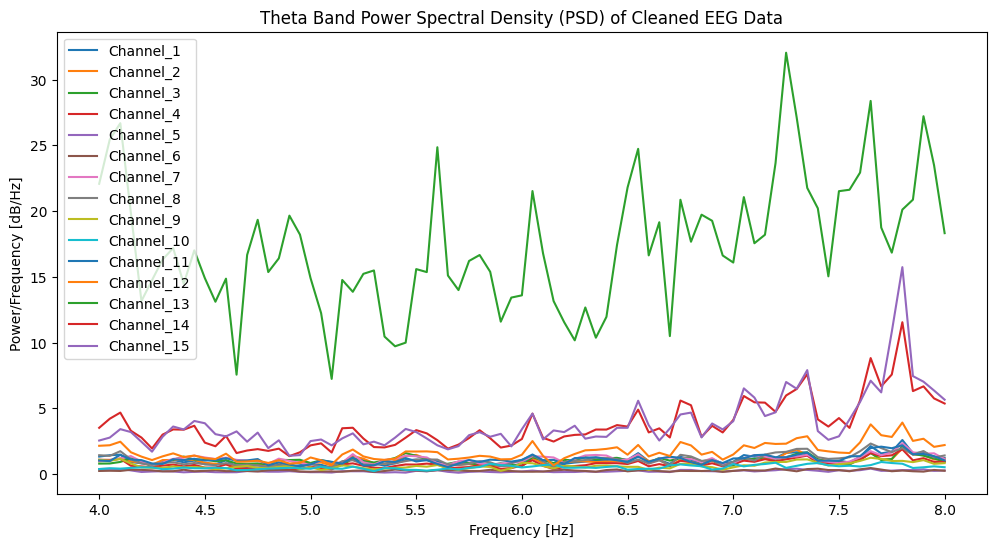

In [151]:
# Plot the theta band data (frequency between 4 to 8) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_theta['freq'], welch_psd_df_theta.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Theta Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_theta.columns[1:])
plt.show()

### Alpha Band

In [152]:
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using plotly express
welch_psd_df_alpha = welch_psd_df[(welch_psd_df['freq']>=8) & (welch_psd_df['freq']<=12)]
fig = px.line(
    welch_psd_df_alpha, 
    x='freq', 
    y=welch_psd_df_alpha.columns[1:], 
    title='Alpha Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

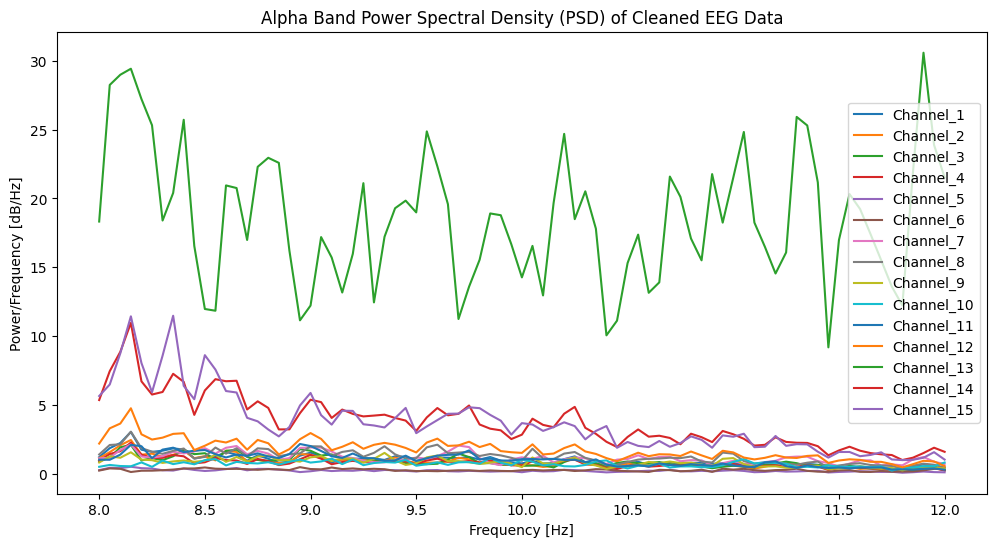

In [153]:
# Plot the alpha band data (frequency between 8 to 12) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_alpha['freq'], welch_psd_df_alpha.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Alpha Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_alpha.columns[1:])
plt.show()

### Beta Band

In [154]:
# Plot the beta band data (frequency between 12 to 30) from welch PSD using plotly express
welch_psd_df_beta = welch_psd_df[(welch_psd_df['freq']>=12) & (welch_psd_df['freq']<=30)]
fig = px.line(
    welch_psd_df_beta, 
    x='freq', 
    y=welch_psd_df_beta.columns[1:], 
    title='Beta Band Power Spectral Density (PSD) of Cleaned EEG Data',
    labels={'freq': 'Frequency (Hz)', 'value': 'Power/Frequency [dB/Hz]'})
# fig.show()

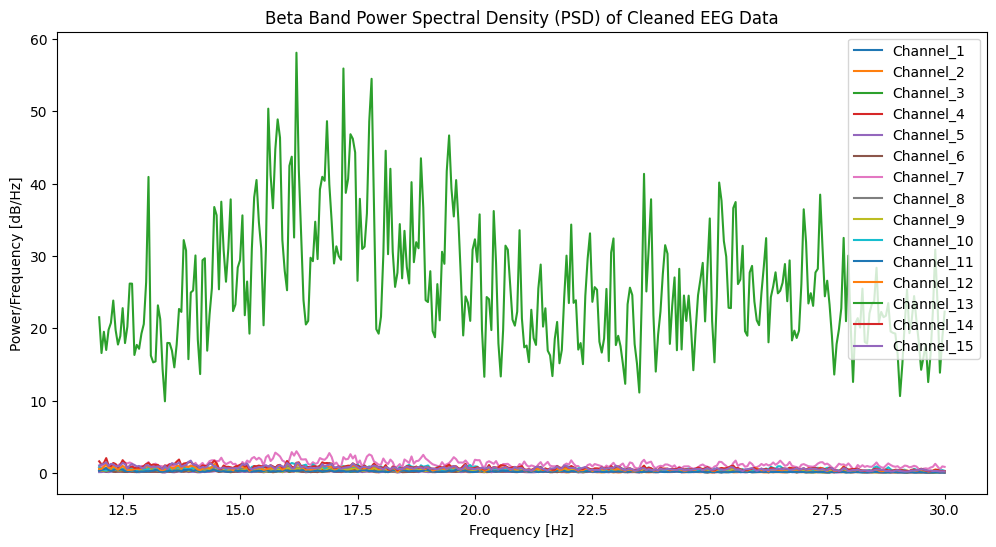

In [155]:
# Plot the beta band data (frequency between 12 to 30) from welch PSD using pyplot
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_beta['freq'], welch_psd_df_beta.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Beta Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_beta.columns[1:])
plt.show()

### Gamma Band

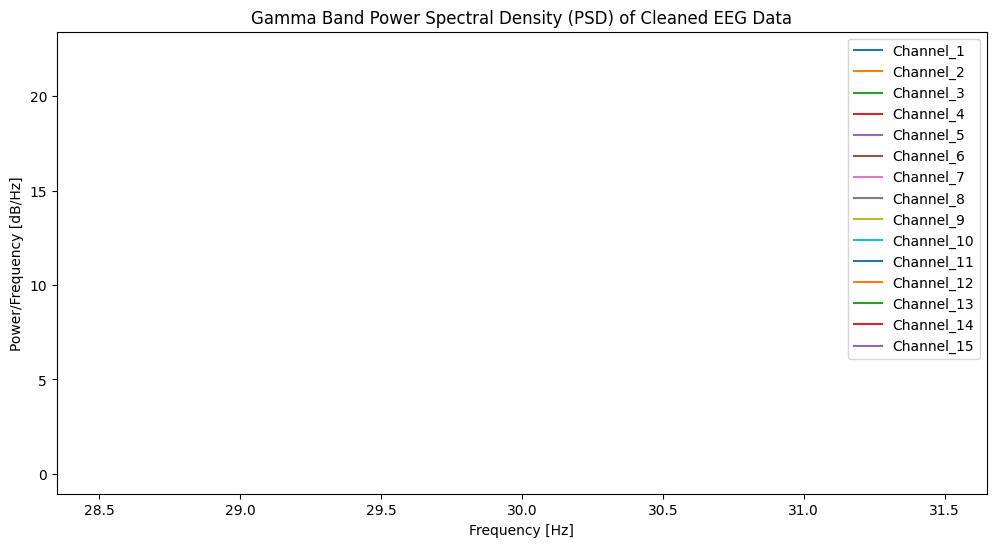

In [156]:
# Plot the gamma band data (frequency between > 30) from welch PSD using pyplot
welch_psd_df_gamma = welch_psd_df[(welch_psd_df['freq']>=30)]
plt.figure(figsize=(12, 6))
plt.plot(welch_psd_df_gamma['freq'], welch_psd_df_gamma.iloc[:,1:])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Gamma Band Power Spectral Density (PSD) of Cleaned EEG Data')
# Add the channel names to the plot
plt.legend(welch_psd_df_gamma.columns[1:])
plt.show()